In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
csv_path = '/content/drive/MyDrive/zavrsni rad/dataset/dataset.csv'
data = pd.read_csv(csv_path)
print(data.head())

                                          image_path  Series  CTDI   kV   mA  \
0  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
1  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
2  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
3  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
4  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   

   size  
0   7.5  
1   7.5  
2   7.5  
3   7.5  
4   7.5  


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader

kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
class AppendixDataset(Dataset):
    def __init__(self, csv_file=None, dataframe=None, transform=None):
        import pandas as pd
        if dataframe is not None:
            self.data = dataframe
        elif csv_file is not None:
            self.data = pd.read_csv(csv_file)
        else:
            raise Exception("CSV path or dataframe required!")
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image = Image.open(row['image_path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        params = torch.tensor([row['CTDI'],row['kV'],row['mA']], dtype=torch.float32)
        label = torch.tensor(row['size'], dtype=torch.float32)
        series = row['Series']

        return image, params, label, series


In [ ]:
resnet = models.resnet18(pretrained=True)

resnet.fc = nn.Identity()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.0MB/s]


In [ ]:
class ParamsMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layers(x)

param_mlp = ParamsMLP()

In [ ]:
class AppendixSizeModel(nn.Module):
    def __init__(self, CTscan_model, param_model):
        super().__init__()
        self.cnn = CTscan_model
        self.param_mlp = param_model
        self.fc = nn.Sequential(
            nn.Linear(512 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, image, params):
        img_feat = self.cnn(image)                              #get features from image using cnn
        param_feat = self.param_mlp(params)                     #get features from scan parameters using MLP
        combined = torch.cat((img_feat, param_feat), dim=1)     #combine image and parameter features
        output = self.fc(combined)                              #predict appendix size
        return output.squeeze(1)

In [ ]:
dataset = AppendixDataset(dataframe=data, transform=image_transforms)



FOLD 1
--------------------
Epoch 1/10 - Train Loss: 40.8782
Epoch 2/10 - Train Loss: 15.0734
Epoch 3/10 - Train Loss: 3.7682
Epoch 4/10 - Train Loss: 0.3879
Epoch 5/10 - Train Loss: 0.1393
Epoch 6/10 - Train Loss: 0.0269
Epoch 7/10 - Train Loss: 0.0111
Epoch 8/10 - Train Loss: 0.0102
Epoch 9/10 - Train Loss: 0.0103
Epoch 10/10 - Train Loss: 0.0056
Validation Loss: 0.0039

FOLD 2
--------------------
Epoch 1/10 - Train Loss: 34.3887
Epoch 2/10 - Train Loss: 10.3974
Epoch 3/10 - Train Loss: 1.8635
Epoch 4/10 - Train Loss: 0.0691
Epoch 5/10 - Train Loss: 0.0810
Epoch 6/10 - Train Loss: 0.0372
Epoch 7/10 - Train Loss: 0.0354
Epoch 8/10 - Train Loss: 0.0221
Epoch 9/10 - Train Loss: 0.0171
Epoch 10/10 - Train Loss: 0.0102
Validation Loss: 0.0042

FOLD 3
--------------------
Epoch 1/10 - Train Loss: 31.8015
Epoch 2/10 - Train Loss: 8.6960
Epoch 3/10 - Train Loss: 1.0270
Epoch 4/10 - Train Loss: 0.0928
Epoch 5/10 - Train Loss: 0.0605
Epoch 6/10 - Train Loss: 0.0272
Epoch 7/10 - Train Loss: 0

/tmp/ipython-input-13-3467174063.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(s) for s in labels], showfliers=False)


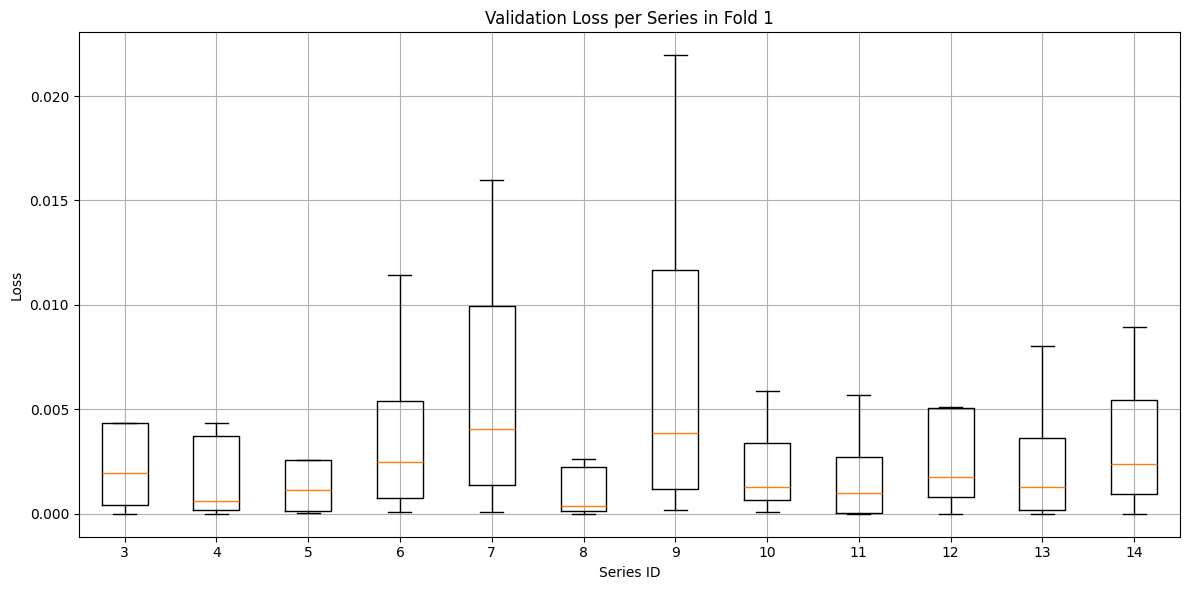

/tmp/ipython-input-13-3467174063.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(s) for s in labels], showfliers=False)


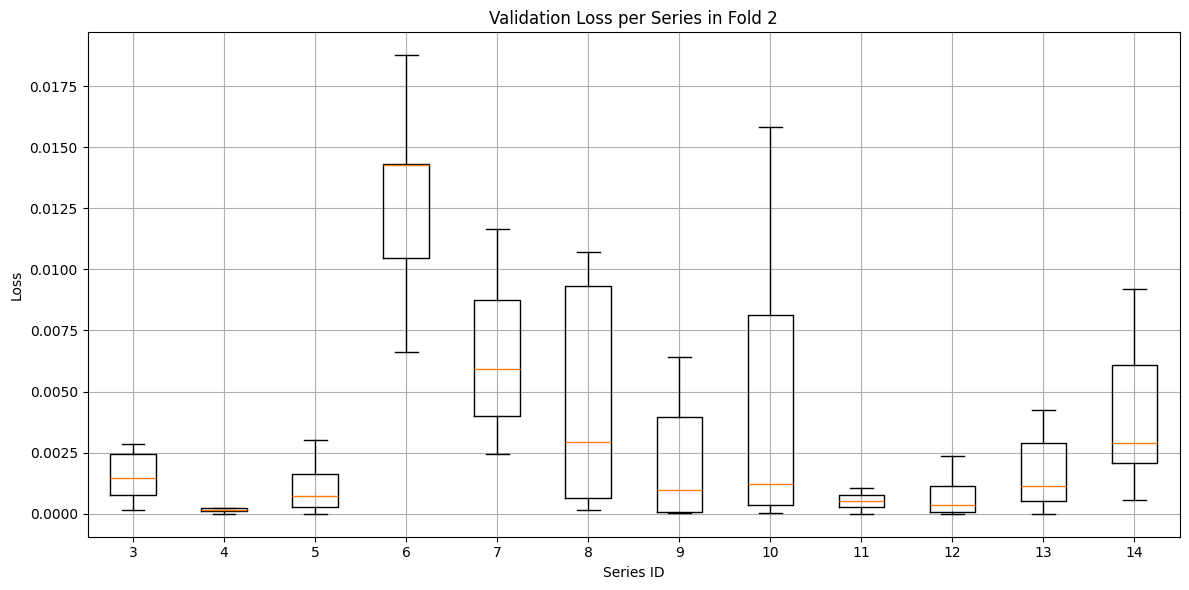

/tmp/ipython-input-13-3467174063.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(s) for s in labels], showfliers=False)


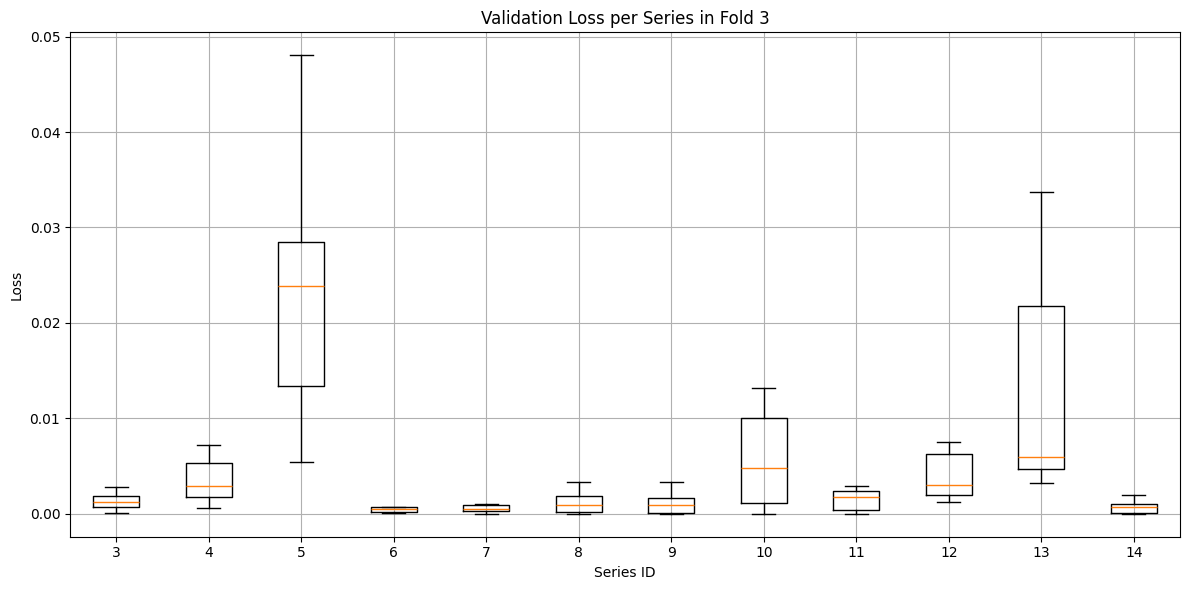

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import torch.nn as nn
import numpy as np

k_folds = 3
batch_size = 16
lr = 1e-4
num_epochs = 10

fold_train_losses = []
fold_val_losses = []
series_losses_by_fold = defaultdict(lambda: defaultdict(list))

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'\nFOLD {fold+1}\n{"-"*20}')

    train_subset = Subset(dataset, train_ids)
    val_subset = Subset(dataset, val_ids)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = AppendixSizeModel(resnet, param_mlp)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, params, labels, _ in train_loader:

            optimizer.zero_grad()
            outputs = model(images, params)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_subset)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_loss = 0
    count = 0

    with torch.no_grad():
        for images, params, labels, series in val_loader:

            outputs = model(images, params)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            count += images.size(0)

            for i in range(images.size(0)):
                s_id = int(series[i].item())
                l = (outputs[i] - labels[i]).pow(2).item()
                series_losses_by_fold[fold][s_id].append(l)

    avg_val_loss = total_loss / count
    print(f"Validation Loss: {avg_val_loss:.4f}")

    fold_val_losses.append(avg_val_loss)

for fold, series_losses in series_losses_by_fold.items():
    plt.figure(figsize=(12, 6))
    labels = sorted(series_losses.keys())
    data = [series_losses[s] for s in labels]

    plt.boxplot(data, labels=[str(s) for s in labels], showfliers=False)
    plt.title(f'Validation Loss per Series in Fold {fold + 1}')
    plt.xlabel('Series ID')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-19-1002431781.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fold_errors_combined, labels=fold_labels, showfliers=False)


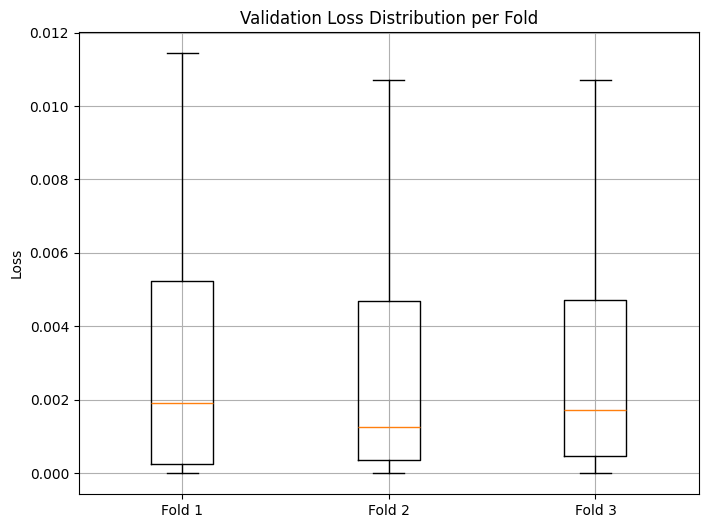

In [ ]:
import matplotlib.pyplot as plt

fold_errors_combined = []
fold_labels = []
for fold, series_losses in series_losses_by_fold.items():
    all_losses = []
    for losses in series_losses.values():
        all_losses.extend(losses)
    fold_errors_combined.append(all_losses)
    fold_labels.append(f'Fold {fold+1}')

plt.figure(figsize=(8,6))
plt.boxplot(fold_errors_combined, labels=fold_labels, showfliers=False)
plt.title("Validation Loss Distribution per Fold")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



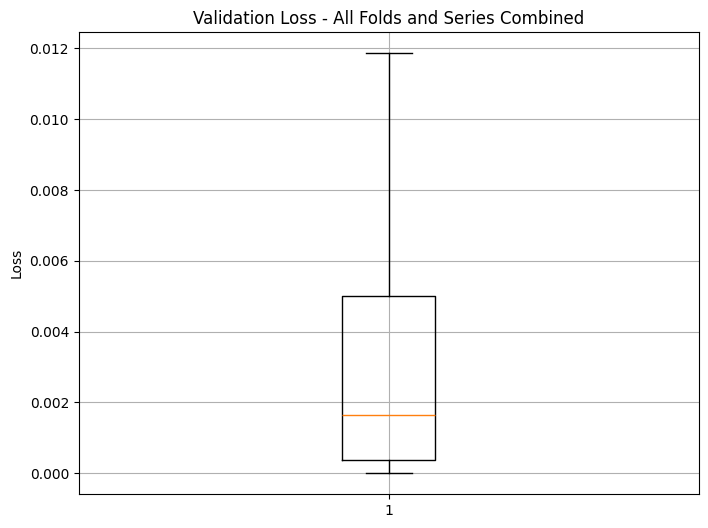

In [ ]:
import matplotlib.pyplot as plt

all_losses = []

for fold in series_losses_by_fold:
    for series_id, losses in series_losses_by_fold[fold].items():
        all_losses.extend(losses)

plt.figure(figsize=(8,6))
plt.boxplot(all_losses, showfliers=False)
plt.title('Validation Loss - All Folds and Series Combined')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


/tmp/ipython-input-22-3671455748.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(s) for s in labels], showfliers=False)


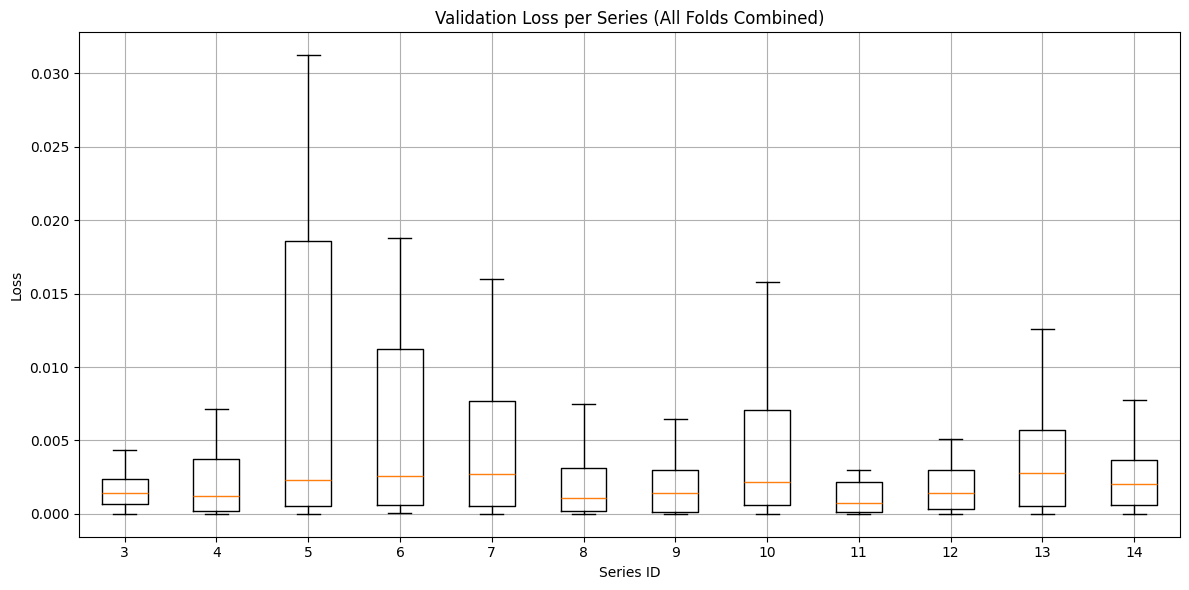

In [ ]:
from collections import defaultdict

combined_series_losses = defaultdict(list)

for fold in series_losses_by_fold:
    for series_id, losses in series_losses_by_fold[fold].items():
        combined_series_losses[series_id].extend(losses)

labels = sorted(combined_series_losses.keys())
data = [combined_series_losses[s] for s in labels]

plt.figure(figsize=(12,6))
plt.boxplot(data, labels=[str(s) for s in labels], showfliers=False)
plt.title('Validation Loss per Series (All Folds Combined)')
plt.xlabel('Series ID')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()
